In [2]:
%reload_ext autoreload
%autoreload 1

%aimport dataloader
%aimport ecg_processing

import pandas as pd
import ast

from dataloader import *
import ecg_processing

In [13]:
# load dataset
labelprep = LabelPreprocessor()
ptbxl_meta = pd.read_csv('../data/ptbxl/ptbxl_database.csv', index_col='ecg_id', na_values=[''])
ptbxl_meta['scp_codes'] = ptbxl_meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

# compute labels test for every task
tasks = [
	'mi_detection',
	'mi_norm_detection',
	'diagnostic',
	'superdiagnostic',
	'subdiagnostic'
]
use_other = [
	False,
	True
]

for task in tasks:
		# uo = False
	for uo in use_other:
		labels, classes, mask = labelprep.compute_labels(ptbxl_meta, task, uo)

		compare_df = pd.DataFrame({
			'ori':ptbxl_meta['scp_codes'],
			'computed_labels':labels,
			'mask':mask
		})

		binarizer_filename = task if not uo else task+'_other'
		labelprep.binarize_fit_save(classes, binarizer_filename)
		multilabel_binary, mlb_cls = labelprep.multi_binarize(labels, binarizer_filename)
		multilabel_df = pd.DataFrame(multilabel_binary, columns=['mlb_'+str(c) for c in mlb_cls])
		multilabel_df.index = compare_df.index
		compare_df = pd.concat([compare_df, multilabel_df], axis=1)
		lb_cls = None
		if len(classes) == 2:
			# since some classes may be empty when use_other=False, this could be bugged
			label_binary, lb_cls = labelprep.binarize(labels, binarizer_filename)
			compare_df['bin_label'] = label_binary

		counts = labelprep.get_class_counts(labels)
		# if task == 'mi_norm_detection':
		# 	for i, label in enumerate(labels):
		# 		if "NORM" in label and any(l != "NORM" for l in label):
		# 			print(f"Overlap at index {i}: {label}")
		print(f'\n==========[{task=}, {uo=}]==========')
		print(counts, f'Total={sum(counts.values())}')
		print(f"Classes: {mlb_cls=} | {lb_cls=}")
		print(compare_df.head(20))

/tmp/ipykernel_1403/3875386670.py:22: UserWarning: task='mi_detection' has single target class ['MI'] but use_other=False. This will cause non-matching samples to have empty labels. Recommended to set use_other=True for binary classification tasks.
  labels, classes, mask = labelprep.compute_labels(ptbxl_meta, task, uo)



==========[task='mi_detection', uo=False]==========
Counter({'MI': 5486}) Total=5486
Classes: mlb_cls=array(['MI'], dtype=object) | lb_cls=None
                                               ori computed_labels   mask  \
ecg_id                                                                      
1         {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}              []  False   
2                     {'NORM': 80.0, 'SBRAD': 0.0}              []  False   
3                       {'NORM': 100.0, 'SR': 0.0}              []  False   
4                       {'NORM': 100.0, 'SR': 0.0}              []  False   
5                       {'NORM': 100.0, 'SR': 0.0}              []  False   
6                       {'NORM': 100.0, 'SR': 0.0}              []  False   
7                       {'NORM': 100.0, 'SR': 0.0}              []  False   
8           {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}            [MI]   True   
9                       {'NORM': 100.0, 'SR': 0.0}              []  False   
10      

In [4]:
# some labelbinarizer logic test
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

data = [[0, 1, 1], [1, 0, 0], [1, 1, 1]]
transform = [[0, 1, 0], [1, 0, 1]]
lb = LabelBinarizer()
lb.fit(data)
lb.transform(transform)

array([[0, 1, 0],
       [1, 0, 1]])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# configure experiment
experiment_id = '20250527_01_resnet'
output_folder = '../myoutput/'
task = 'mi_detection'
preprocessor_code = 'basic'
num_classes = 2
sampling_freq = 500
signal_length = 5000
batch_size = 64
num_epochs = 30

In [15]:
# create and initialize preprocessor
sigprep = SignalPreprocessor()
sigprep.load('basic')

In [23]:
sigprep.preprocess_all(fs=100)

Preprocessing all to file: 100%|██████████| 21837/21837 [01:59<00:00, 182.39record/s, Attempting write: ../mydata/records100/21000/21837_lr.npy to ../mydata/records100/21000]


In [24]:
sigprep.preprocess_all(fs=500)

Initializing fitting dataset


Preprocessing all to file: 100%|██████████| 21837/21837 [04:16<00:00, 85.29record/s, Attempting write: ../mydata/records500/21000/21837_hr.npy to ../mydata/records500/21000] 


In [25]:
# check contents
print(sigprep.__dict__)

{'n_channels': 12, 'subset': None, 'dataset': <dataloader.PTBXL object at 0x7d2bc45d5490>, 'loader': <torch.utils.data.dataloader.DataLoader object at 0x7d2bbdd140a0>, 'fs': 500, 'ch_means': array([-1.09727875e-19,  9.65844071e-20, -8.39369743e-20, -7.06361638e-20,
        2.58262298e-19,  5.51549403e-20, -1.16635381e-19, -2.47946781e-19,
       -2.24761929e-19,  2.95806860e-19, -5.79371485e-20, -9.69866042e-20]), 'ch_stds': array([0.15249077, 0.1423526 , 0.14098492, 0.12738461, 0.12621301,
       0.12047433, 0.2027735 , 0.31429522, 0.30331787, 0.27017268,
       0.24446178, 0.19495041]), 'ch_means_arr': array([[[-1.0972787e-19],
        [ 9.6584407e-20],
        [-8.3936977e-20],
        [-7.0636164e-20],
        [ 2.5826231e-19],
        [ 5.5154943e-20],
        [-1.1663539e-19],
        [-2.4794677e-19],
        [-2.2476193e-19],
        [ 2.9580687e-19],
        [-5.7937145e-20],
        [-9.6986604e-20]]], dtype=float32), 'ch_stds_arr': array([[[0.15249078],
        [0.1423526 ],

In [41]:
# filter test
dataset = PTBXL(mode='raw', sampling_frequency=sampling_freq)
ecg_id = 40 # some random ecg

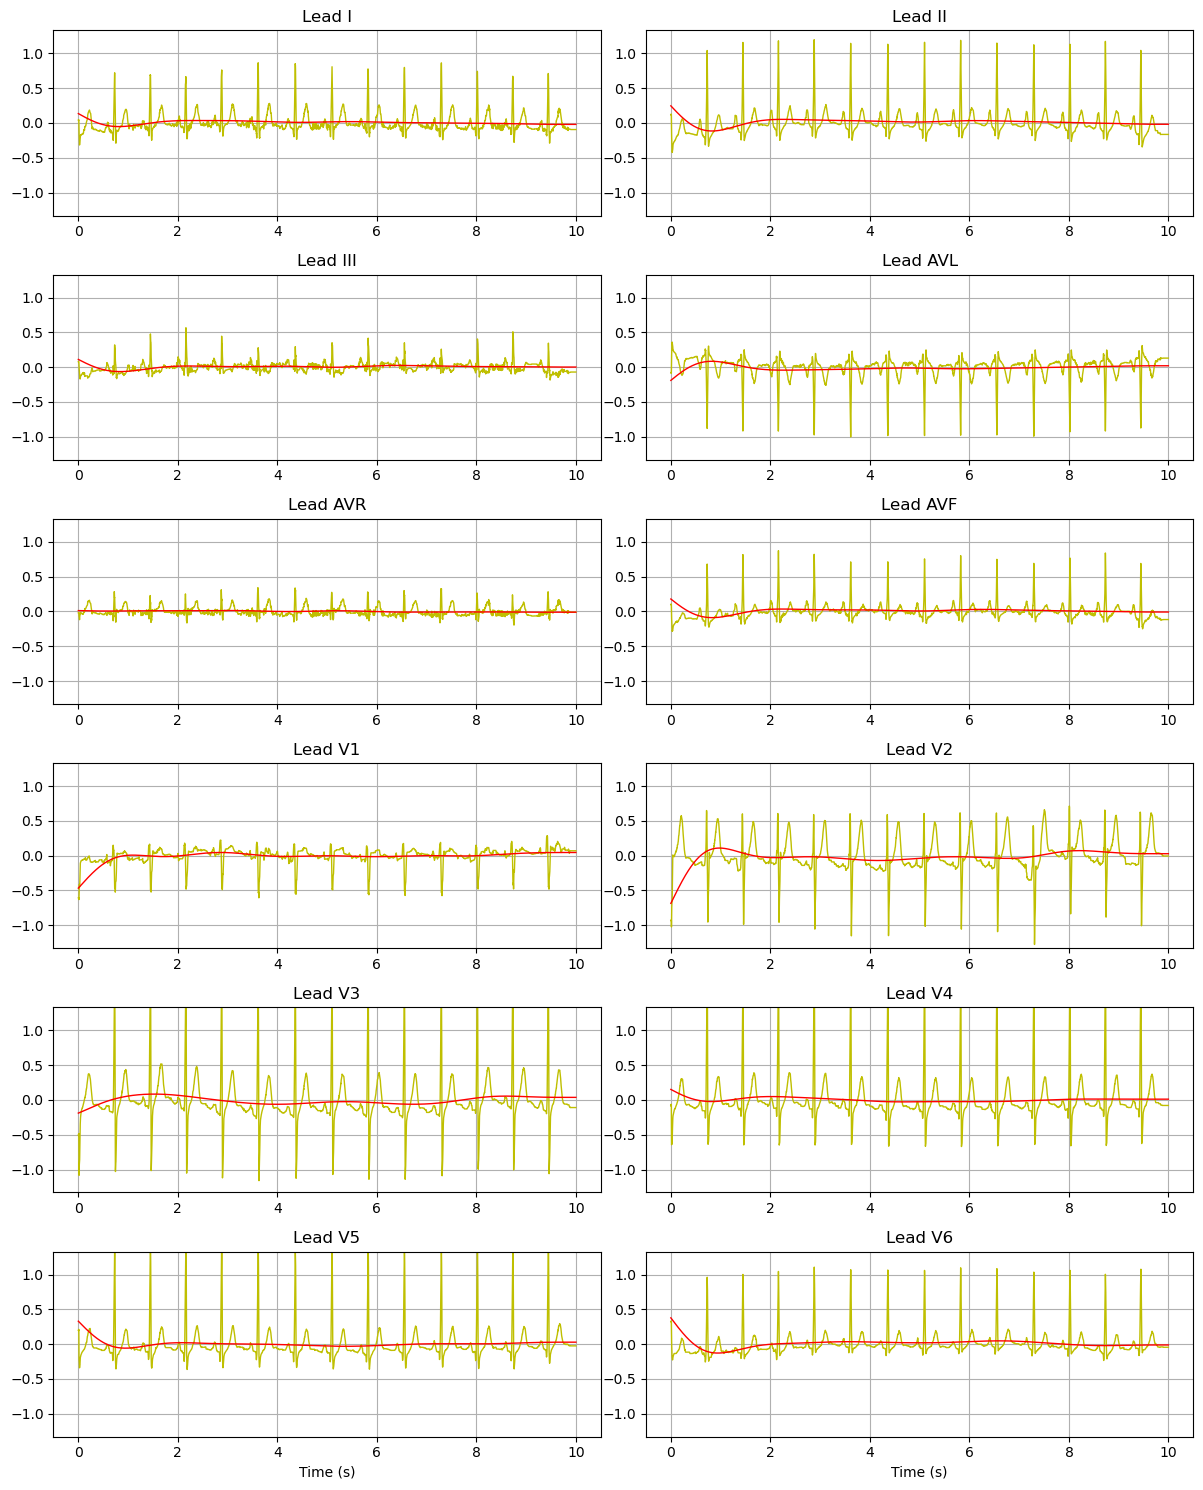

In [39]:
ecg, label = dataset[ecg_id]
baseline = sigprep.apply_lowpass(ecg, sampling_freq, 0.5)
ecg_processing.plot_ecg_record(ecg, sampling_freq, baseline)

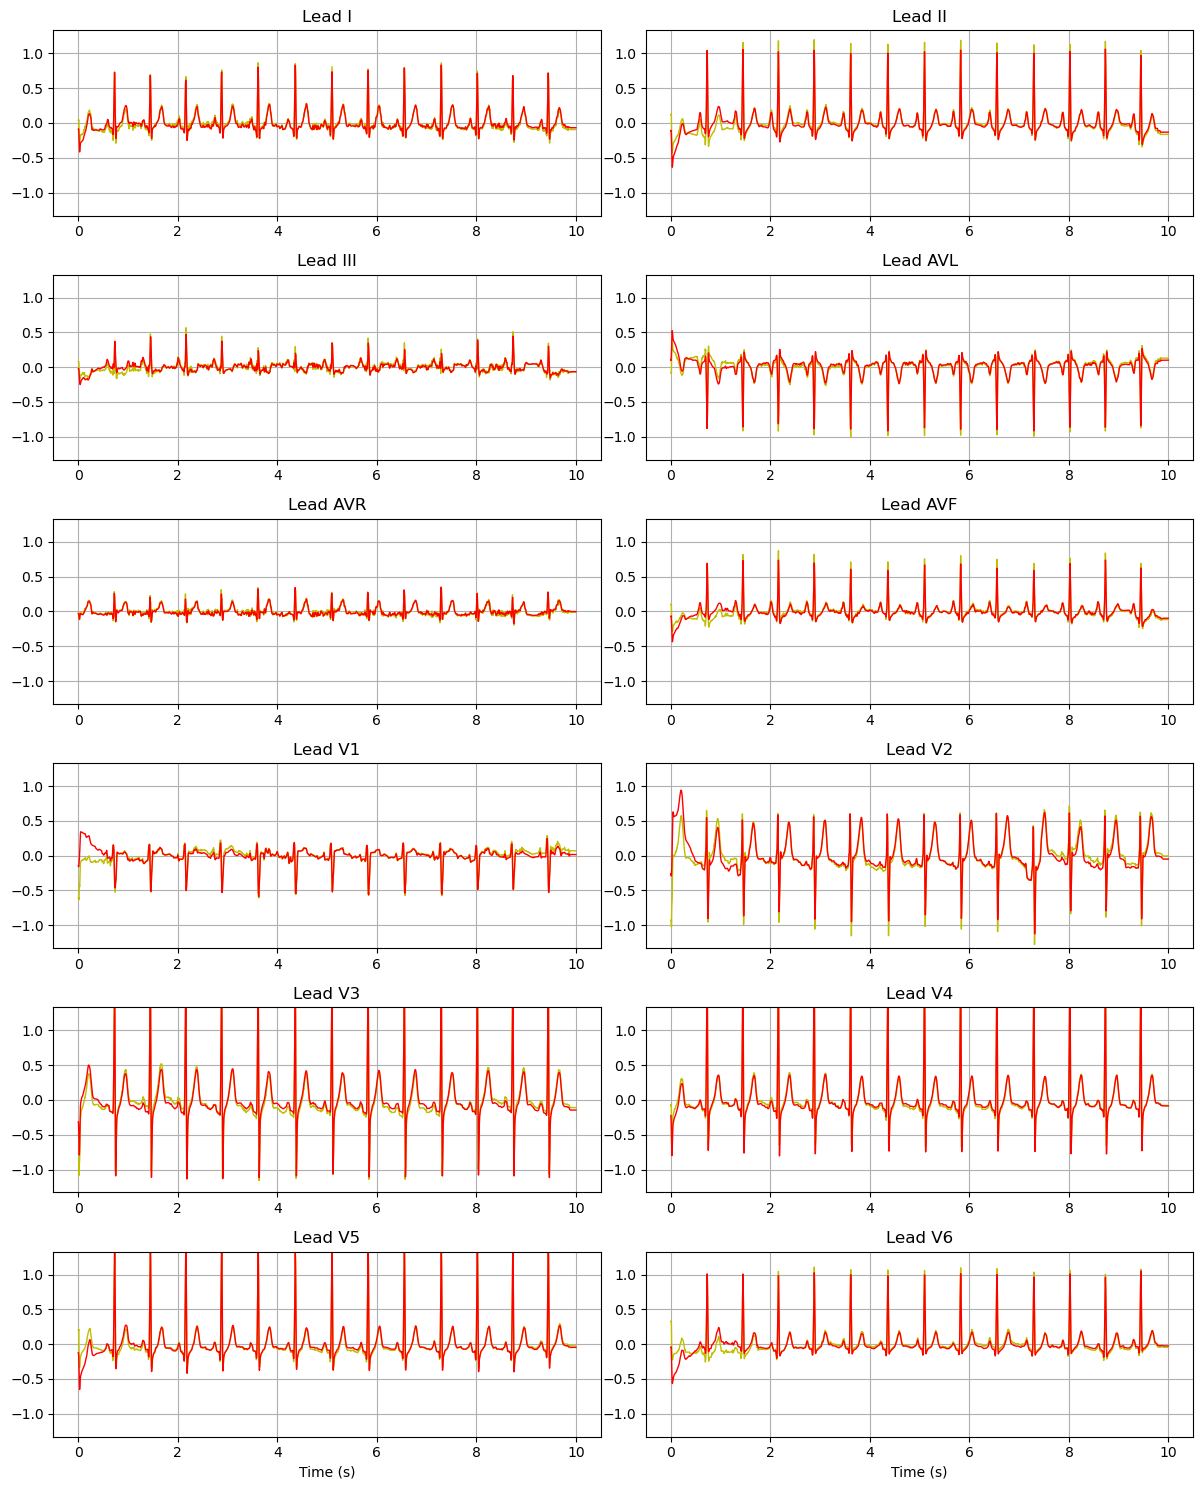

In [42]:
filtered = sigprep.denoise(ecg, sampling_freq)
ecg_processing.plot_ecg_record(ecg, sampling_freq, filtered)

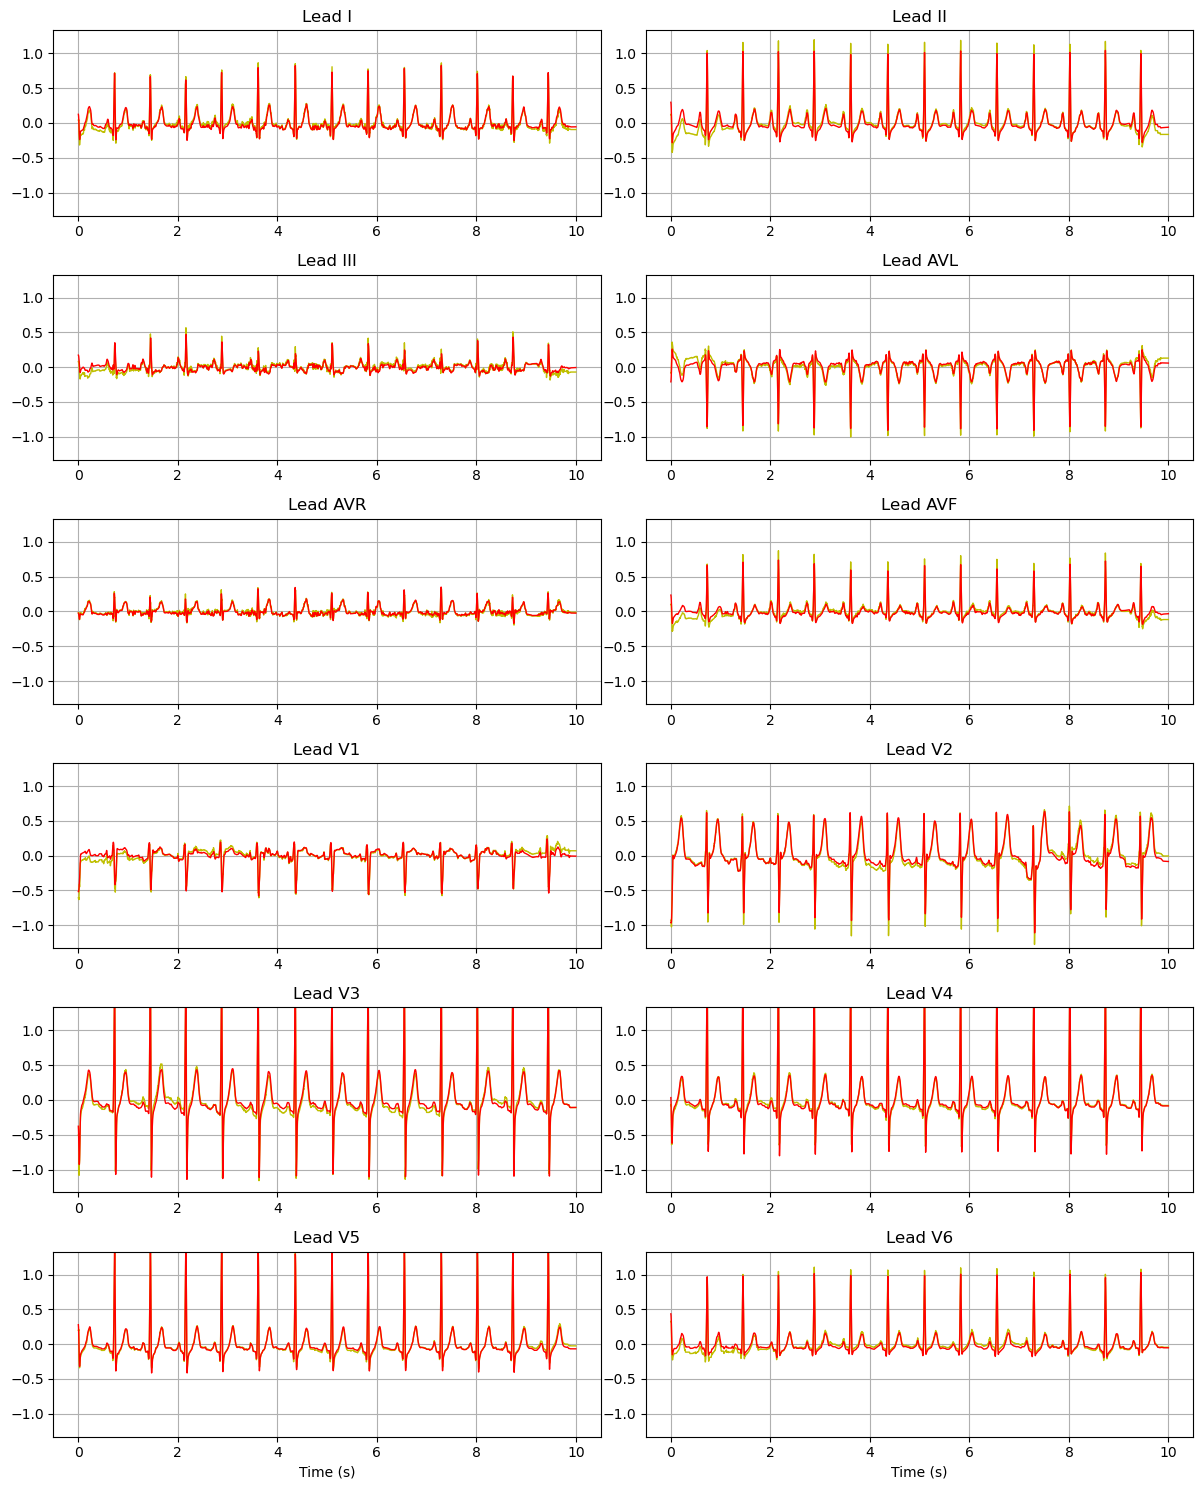

In [50]:
baseline2 = sigprep.apply_lowpass(ecg, sampling_freq, 0.5)
filtered2 = sigprep.denoise(ecg, sampling_freq)
ecg_processing.plot_ecg_record(ecg, sampling_freq, filtered2)

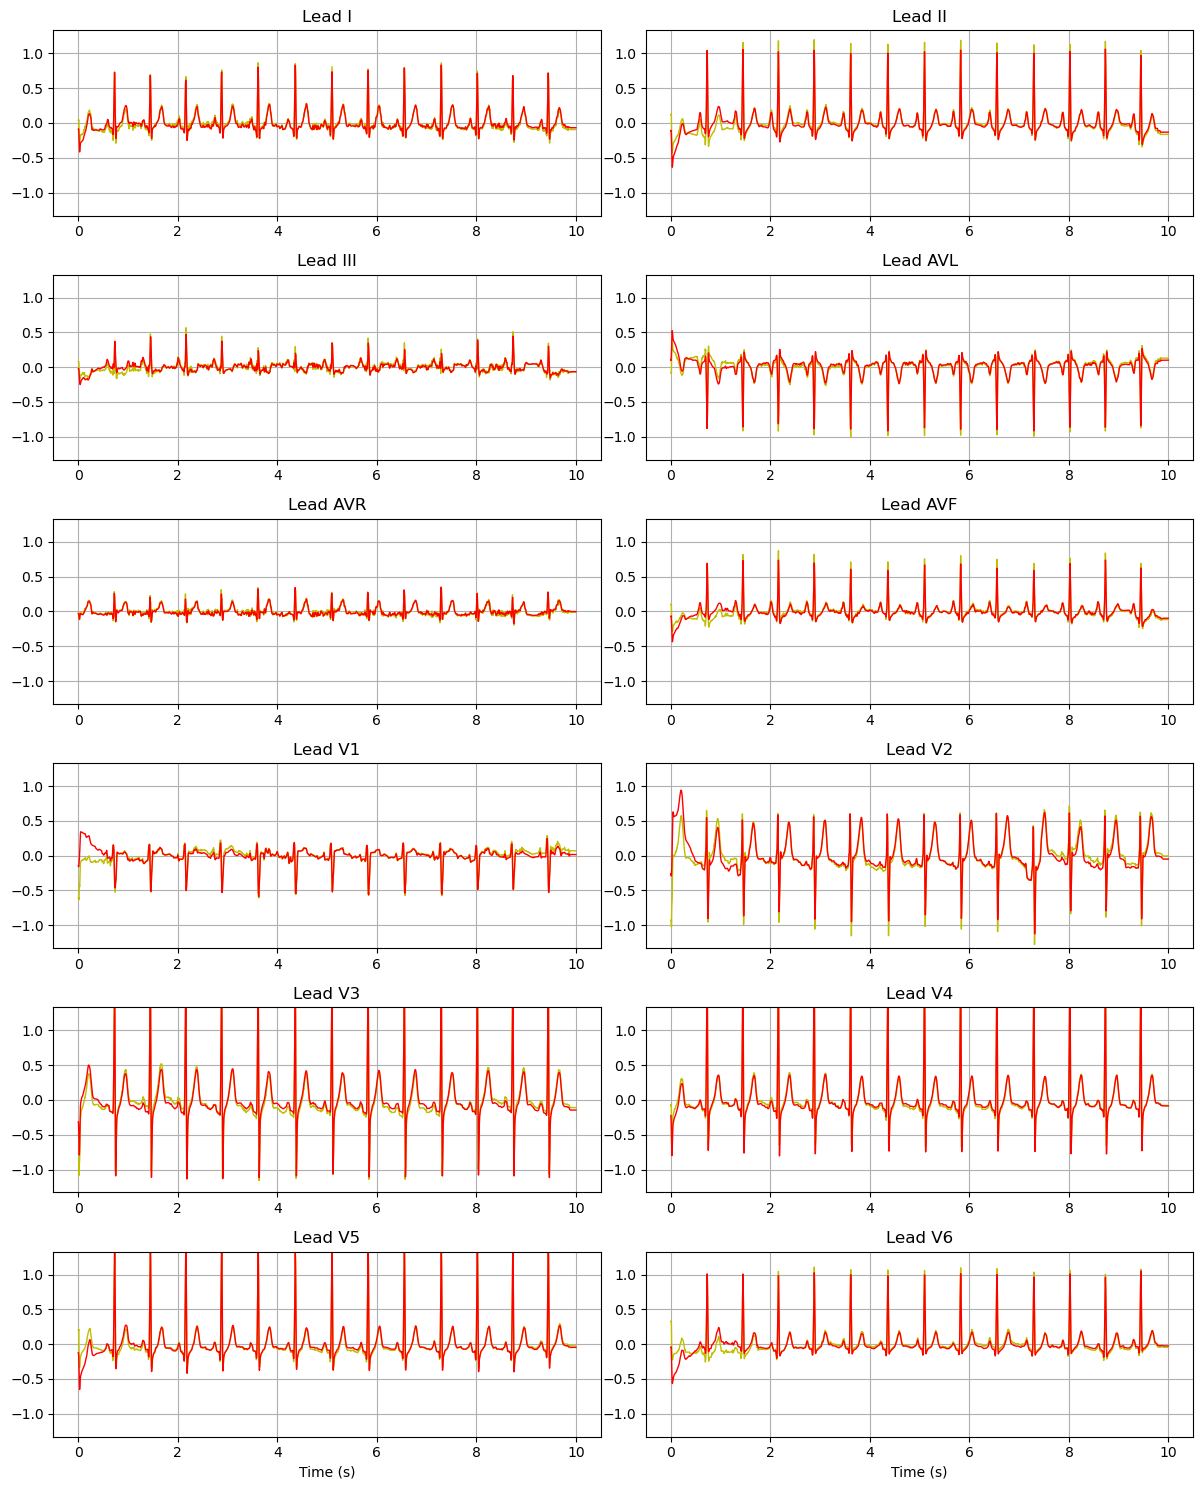

In [40]:
filtered = sigprep.denoise(ecg, sampling_freq)
ecg_processing.plot_ecg_record(ecg, sampling_freq, filtered)

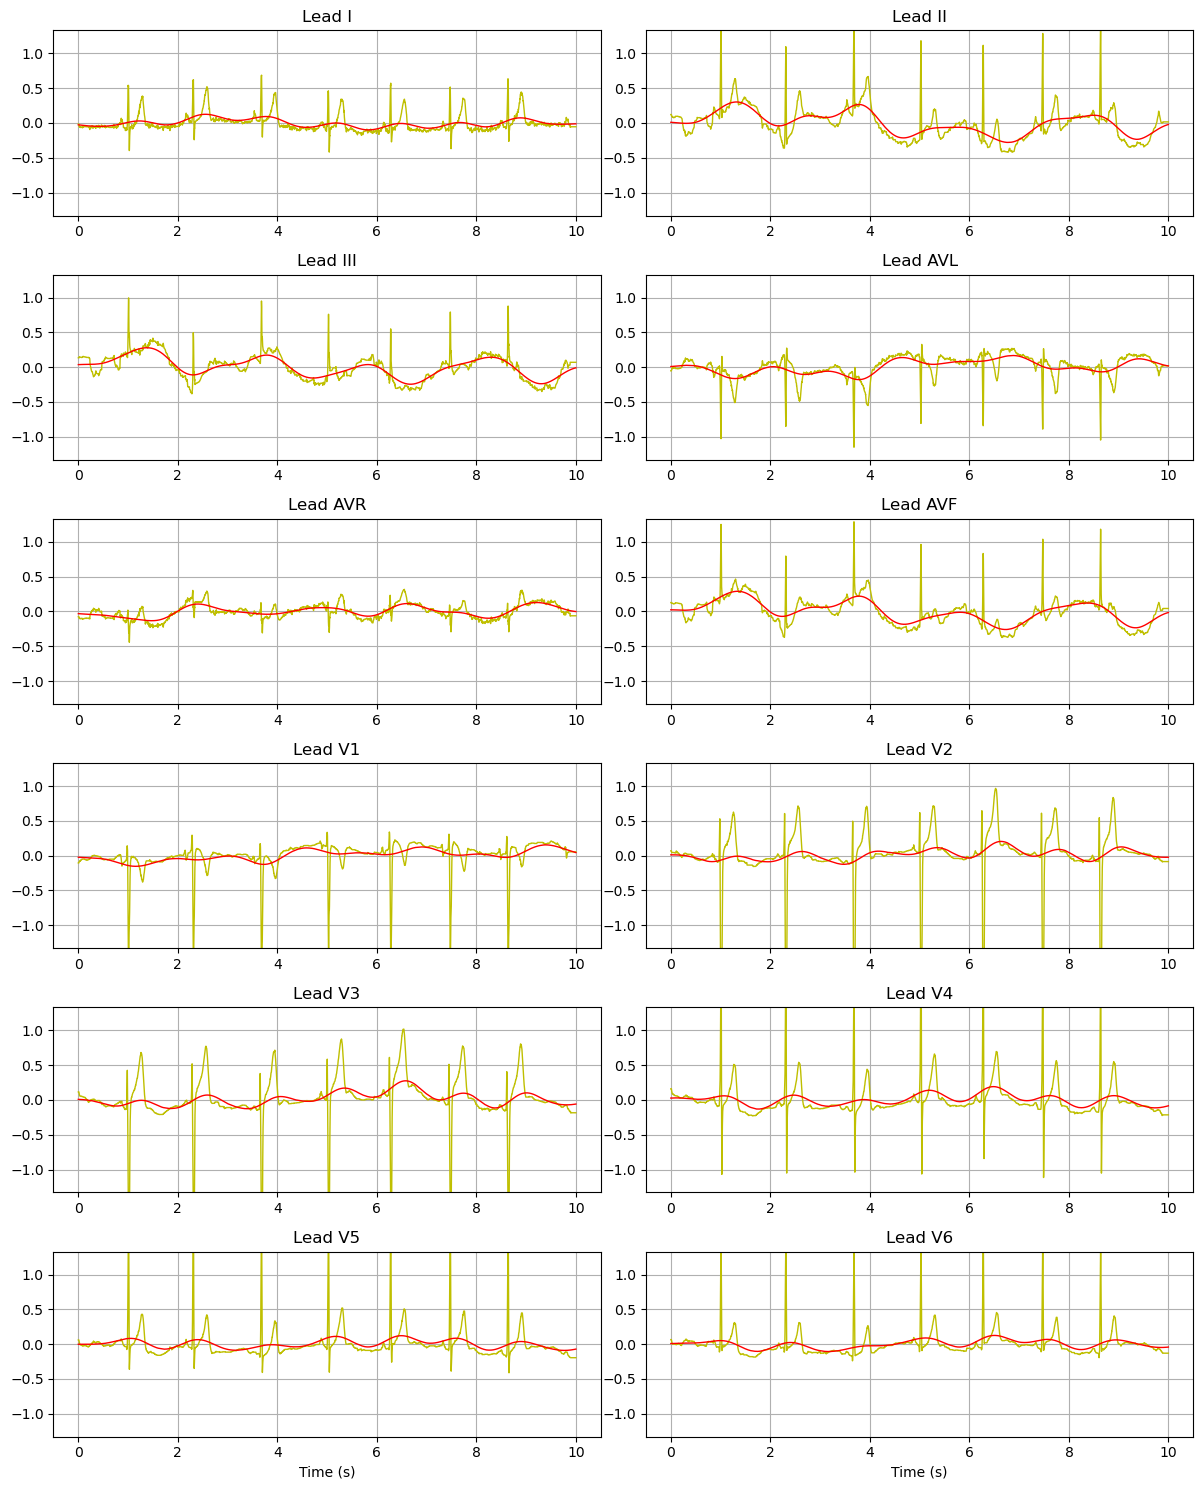

In [ ]:
ecg, label = dataset[ecg_id]
baseline = sigprep.lpf_lo(ecg, sampling_freq)
ecg_processing.plot_ecg_record(ecg, sampling_freq, baseline)

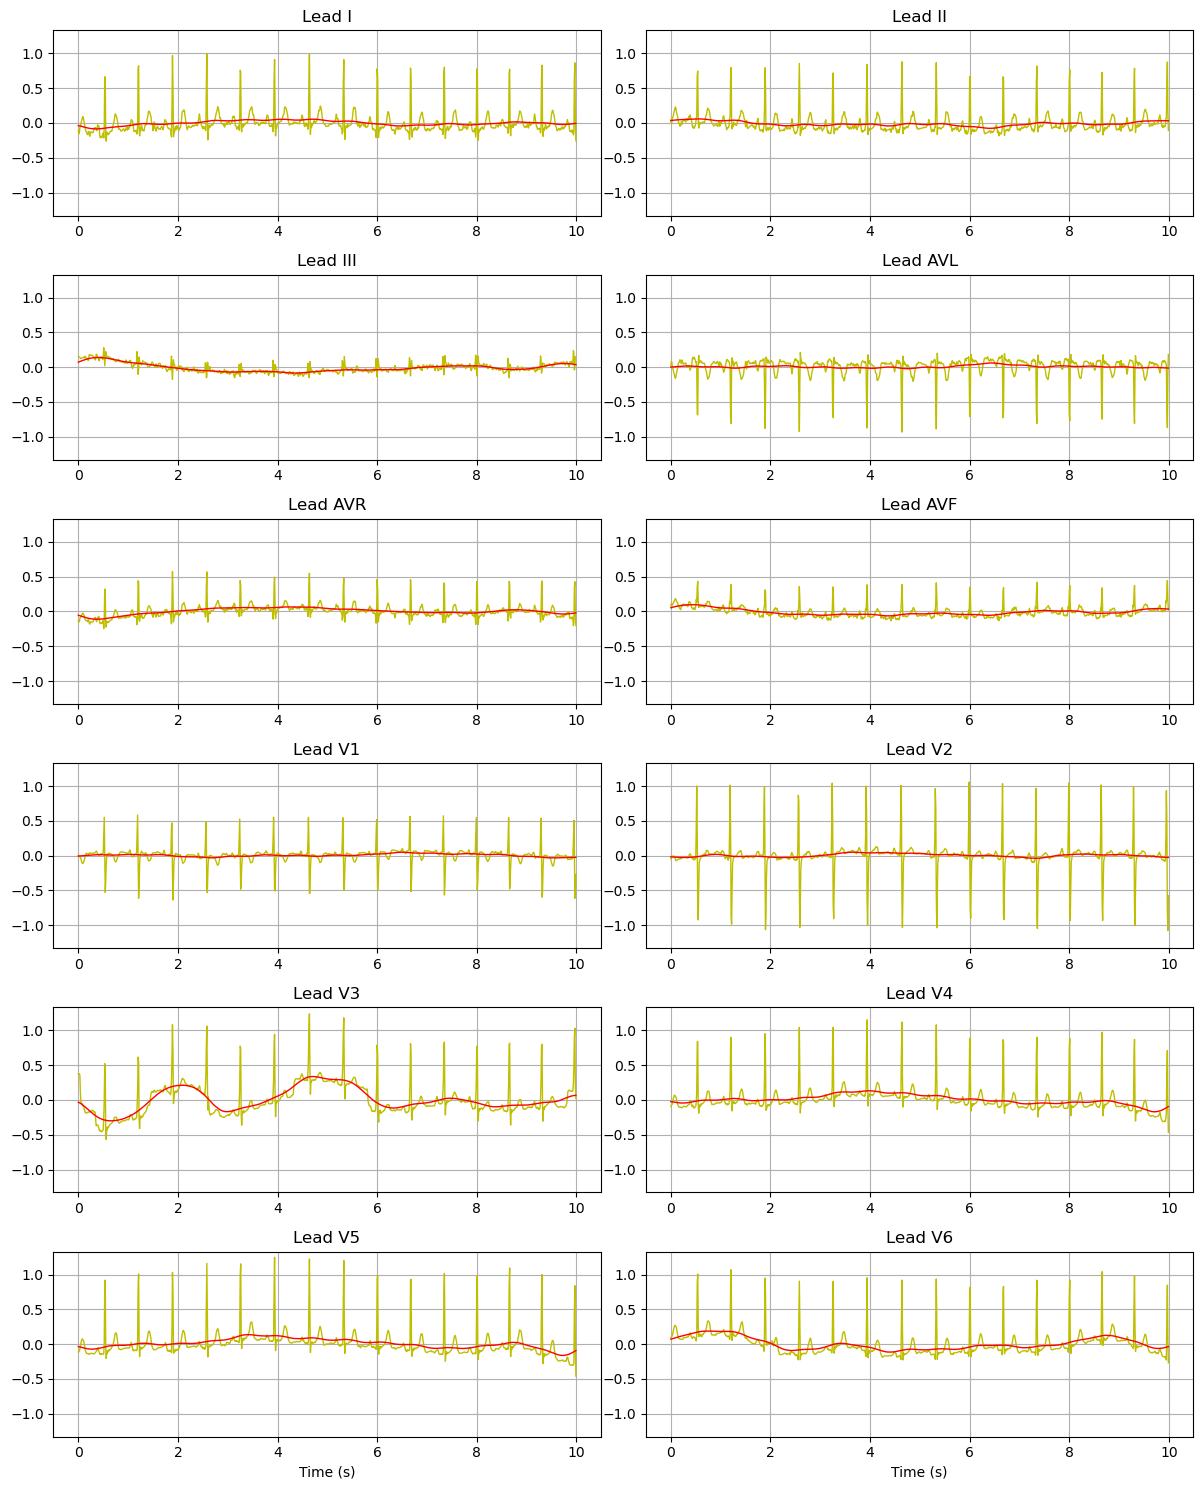

In [ ]:
ecg, label = dataset_lr[ecg_id]
baseline = sigprep.lpf_lo(ecg, sampling_freq)
ecg_processing.plot_ecg_record(ecg, sampling_freq, baseline)

In [ ]:
sigprep.save(preprocessor_code)